<h2> Importando bibliotecas

In [1]:
#https://medium.com/analytics-vidhya/how-to-summarize-data-with-pandas-2c9edffafbaf
#https://www.programcreek.com/python/example/96216/seaborn.set_context
#https://towardsdev.com/outlier-detection-using-iqr-method-and-box-plot-in-python-82e1e15232bd

import requests as rq
import pandas as pd

pd.set_option('display.max_columns', None)  # or 1000
#pd.set_option('display.max_colwidth', -1)  # or 199
pd.set_option('float_format', '{:,.2f}'.format)
#pd.options.display.float_format = 

from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")

<h2> Importando o dataframe do arquivo principal

In [2]:
df_header = pd.read_pickle('Header.pkl')

<h2> Importando o arquivo dos itens em dataframe

In [3]:
url = "https://github.com/kairobeduti/DadosShift/blob/master/Itens/Api_Itens.xlsx?raw=true"
data = rq.get(url).content
df_itens = pd.read_excel(BytesIO(data))

In [4]:
url = "https://github.com/kairobeduti/DadosShift/blob/master/Cadastro%20Fam%C3%ADlias%20Petronect/Geral.xlsx?raw=true"
data = rq.get(url).content
df_familias = pd.read_excel(BytesIO(data))
df_familias.drop(['Tipo da Família','Família'],axis=1,inplace=True)

In [5]:
display(f'itens {df_itens.shape}')
df_itens.info()
df_itens.drop(['Unnamed: 0','EXLIN','YPCOMT_LINE','ATTACHMENTS','SRC_GUID','ITEM_PROCESS_TYP'], axis=1,inplace=True)

'itens (37381, 18)'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37381 entries, 0 to 37380
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        37381 non-null  int64  
 1   SRC_GUID          37381 non-null  object 
 2   NUMBER_INT        37381 non-null  object 
 3   DESCRIPTION_UC    37364 non-null  object 
 4   ORDERED_PROD      28601 non-null  object 
 5   YPFAMITEM         32303 non-null  float64
 6   QUANTITY          37381 non-null  float64
 7   UNIT              36387 non-null  object 
 8   UNIT_TEXT         35098 non-null  object 
 9   DELIV_DATE        37381 non-null  object 
 10  EXLIN             37381 non-null  object 
 11  GROUPING_LEVEL    5083 non-null   object 
 12  ITEM_PROCESS_TYP  37361 non-null  object 
 13  YPCOMT_LINE       37381 non-null  object 
 14  ATTACHMENTS       37381 non-null  object 
 15  LOTE              988 non-null    object 
 16  TOTAL             4095 non-null   object

In [6]:
df = df_header.merge(df_itens, on='OPPORT_NUM', how='inner')
df = df.merge(df_familias, on='YPFAMITEM', how='inner')

In [7]:
url = "https://github.com/kairobeduti/DadosShift/blob/master/Hist%C3%B3rico/Historico_QUOTS.xlsx?raw=true"
data = rq.get(url).content
df_quots = pd.read_excel(BytesIO(data))
df_quots.drop(['Unnamed: 0','DESCRIPTION'],axis=1,inplace=True)

In [8]:
df_quots = df_quots.query('TOTAL_VALUE != "Decline"')

In [9]:
df = df.merge(df_quots, on=['OPPORT_NUM','NUMBER_INT'],how='inner')

Text(0.5, 1.0, 'Valores Faltantes')

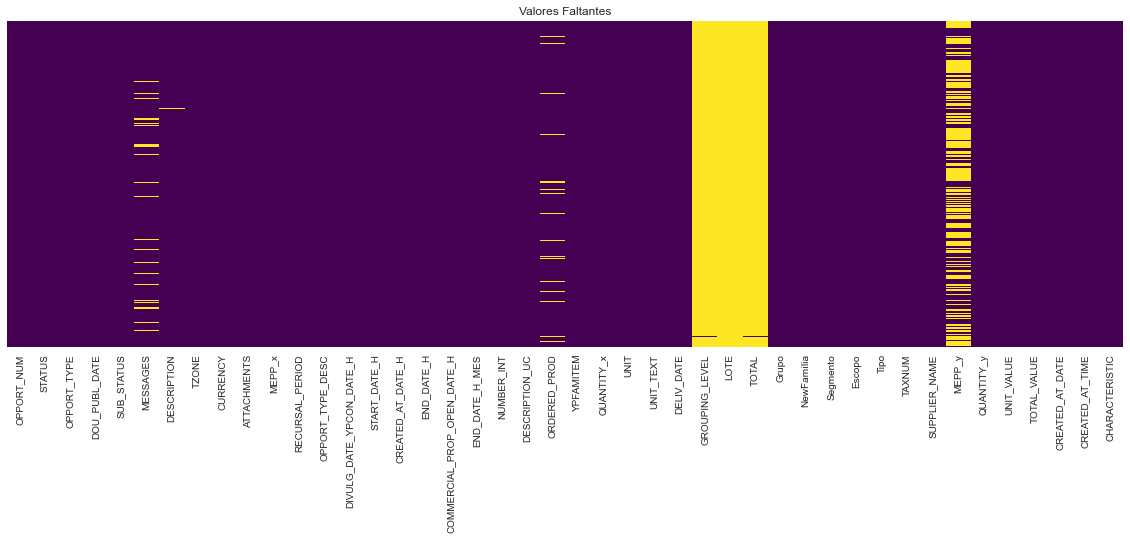

In [10]:
plt.figure(figsize=(20,6))
sns.heatmap(df.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Valores Faltantes')

In [11]:
for x,t in enumerate(df.columns.to_list()):
    if t.__contains__('x') or t.__contains__('y') :
        print(t)
set(df['QUANTITY_x'] == df['QUANTITY_y'])
df_diff_qtd = df[df['QUANTITY_x'] != df['QUANTITY_y']]

MEPP_x
QUANTITY_x
MEPP_y
QUANTITY_y


In [12]:
df_colunas_obj = df.loc[:, df.dtypes == object]
cols_object = df_colunas_obj.describe().T
cols_object = cols_object.reset_index()
cols_object['dist_uniques'] = (cols_object['unique'] / cols_object['count'])*100
cols_object = cols_object[cols_object['dist_uniques']<80]
lista_objects = cols_object['index'].to_list()
print(lista_objects)

['STATUS', 'OPPORT_TYPE', 'MESSAGES', 'DESCRIPTION', 'TZONE', 'CURRENCY', 'ATTACHMENTS', 'MEPP_x', 'OPPORT_TYPE_DESC', 'NUMBER_INT', 'DESCRIPTION_UC', 'ORDERED_PROD', 'UNIT', 'UNIT_TEXT', 'DELIV_DATE', 'GROUPING_LEVEL', 'TOTAL', 'Grupo', 'NewFamília', 'Segmento', 'Escopo', 'Tipo', 'TAXNUM', 'SUPPLIER_NAME', 'MEPP_y', 'UNIT_VALUE', 'TOTAL_VALUE', 'CREATED_AT_DATE', 'CREATED_AT_TIME', 'CHARACTERISTIC']


In [13]:
df_familias = df[['Grupo','NewFamília','OPPORT_NUM','Segmento','Escopo','Tipo']]
#df_familias = df[['Grupo','NewFamília','OPPORT_NUM','Segmento','Escopo','Tipo','DURACAO']]
df_familias = df_familias.drop_duplicates()
#df_familias = df_familias[df_familias['Tipo']=='Bens']

In [14]:
df_familias_stats = df_familias.describe(include='O').T.sort_values('unique')
df_familias_stats['rel'] = (df_familias_stats['freq'] / df_familias_stats['count'])*100
df_familias_stats

,count,unique,top,freq,rel
Tipo,3133,2,Bens,3123,99.68
Segmento,3133,4,Crítica,1169,37.31
Grupo,3133,23,M-40 - Sistemas de distribuição e condicioname...,1115,35.59
NewFamília,3133,584,- Feixe tubular,86,2.74
Escopo,3133,584,Componentes especialmente fabricados para os p...,86,2.74


In [15]:
df_fam_mat_type = df_familias[['Tipo']].value_counts(normalize=True).rename('%').mul(100).reset_index().sort_values('%', ascending=False)
df_fam_segmento = df_familias[['Tipo','Segmento']].value_counts(normalize=True).rename('%').mul(100).reset_index().sort_values('%', ascending=False)
df_fam_grupo = df_familias[['Tipo','Grupo']].value_counts(normalize=True).rename('%').mul(100).reset_index().sort_values('%', ascending=False)
df_fam_desc = df_familias[['Tipo','NewFamília']].value_counts(normalize=True).rename('%').mul(100).reset_index().sort_values('%', ascending=False)[:20]

Text(0.5, 0, 'Item Process Type')

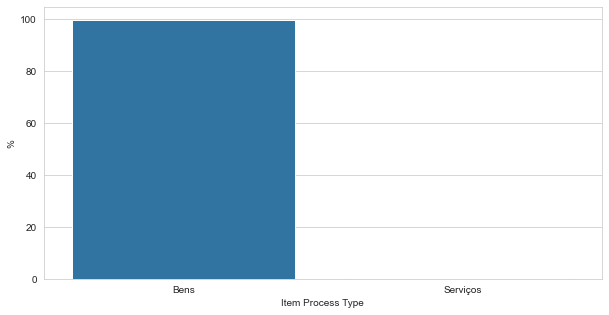

In [16]:
f, ax = plt.subplots(figsize=(10,5))
f.subplots_adjust(hspace=0.5, wspace=.2)
sns.barplot(data=df_fam_mat_type, x='Tipo', y='%')
ax.set_xlabel('Item Process Type')

Text(0.5, 0, 'Item Process Type')

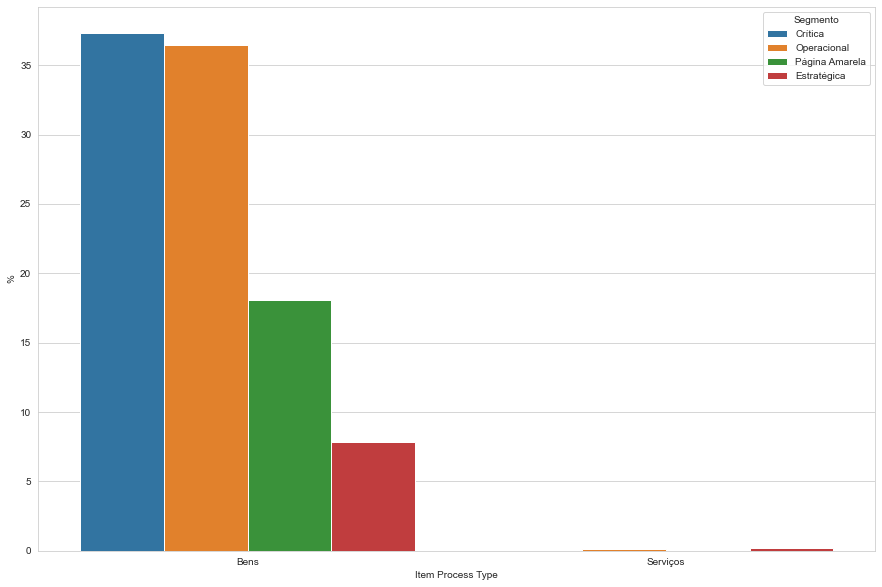

In [17]:
f, ax = plt.subplots(figsize=(15,10))
f.subplots_adjust(hspace=0.5, wspace=.2)
sns.barplot(data=df_fam_segmento, x='Tipo', y='%', hue='Segmento')
ax.set_xlabel('Item Process Type')

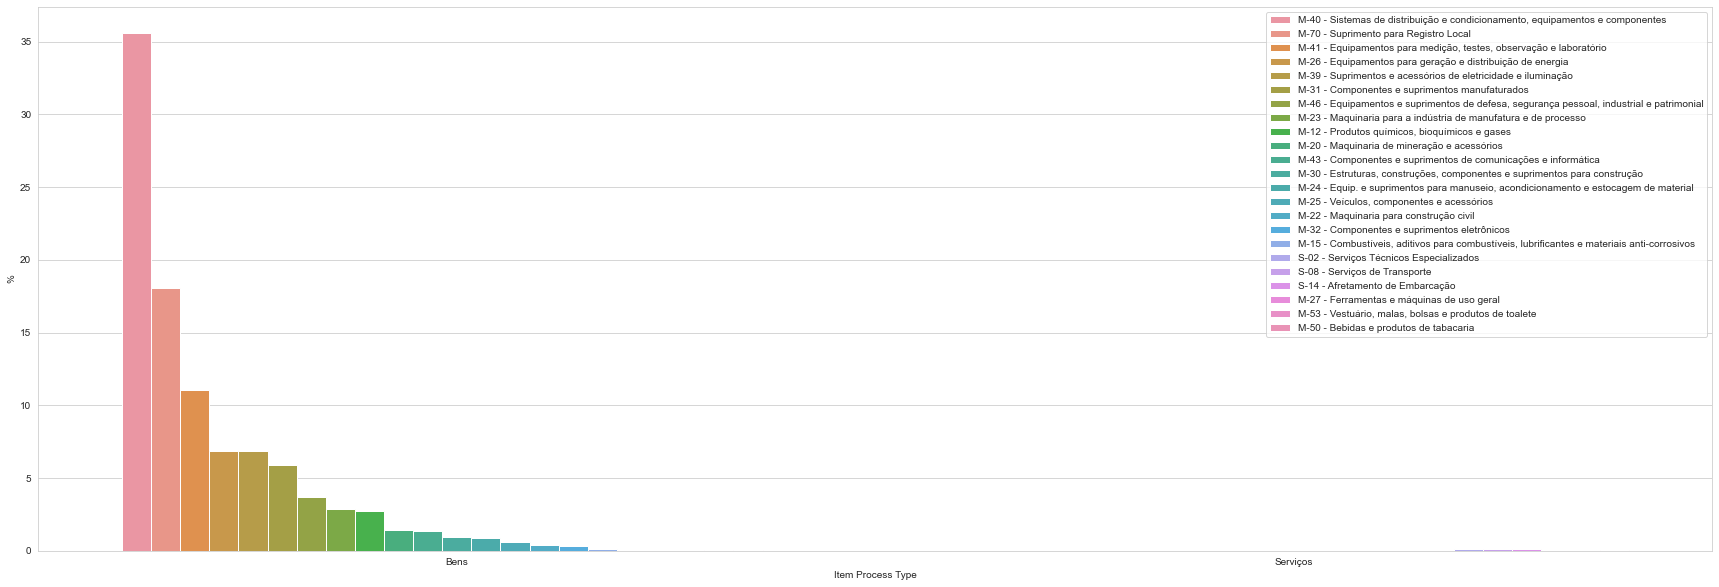

In [18]:
f, ax = plt.subplots(figsize=(30,10))
f.subplots_adjust(hspace=0.5, wspace=.2)
sns.barplot(data=df_fam_grupo, x='Tipo', y='%', hue='Grupo')
ax.set_xlabel('Item Process Type')
ax.legend(loc='upper right')

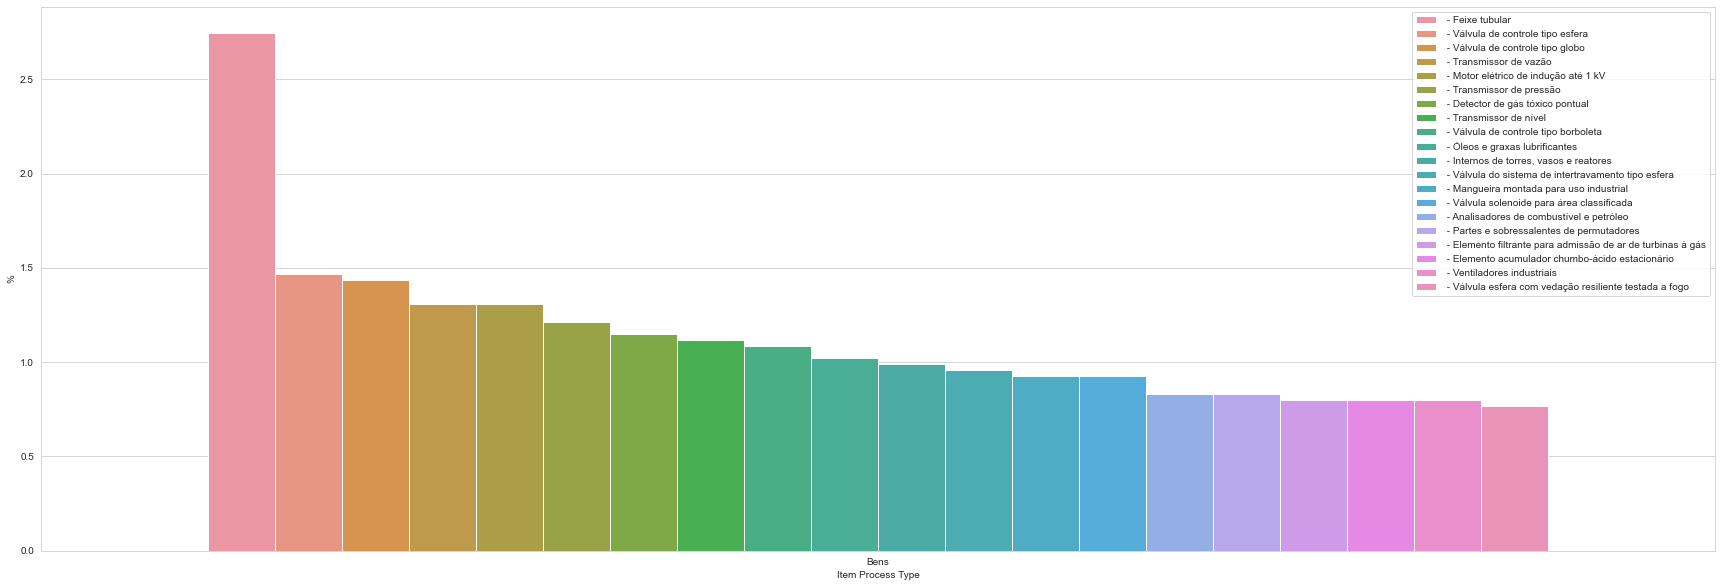

In [19]:
f, ax = plt.subplots(figsize=(30,10))
f.subplots_adjust(hspace=0.5, wspace=.2)
sns.barplot(data=df_fam_desc, x='Tipo', y='%', hue='NewFamília')
ax.set_xlabel('Item Process Type')
ax.legend(loc="upper right")

In [20]:
df['UNIT_VALUE_tmp'] = df['UNIT_VALUE'].str.replace('.','').str.strip()
df['UNIT_VALUE'] = df['UNIT_VALUE_tmp'].str.replace(',','.').astype('float')
df.drop('UNIT_VALUE_tmp', axis=1,inplace=True)

C:\Users\kairo\AppData\Local\Temp\ipykernel_30852\1534235725.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['UNIT_VALUE_tmp'] = df['UNIT_VALUE'].str.replace('.','').str.strip()


In [21]:
df['TOTAL_VALUE_tmp'] = df['TOTAL_VALUE'].str.replace('.','').str.strip()
df['TOTAL_VALUE'] = df['TOTAL_VALUE_tmp'].str.replace(',','.').astype('float')
df.drop('TOTAL_VALUE_tmp', axis=1,inplace=True)

C:\Users\kairo\AppData\Local\Temp\ipykernel_30852\1323756818.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['TOTAL_VALUE_tmp'] = df['TOTAL_VALUE'].str.replace('.','').str.strip()


In [22]:
df['Chave'] = df['OPPORT_NUM'].astype('str') + '--'  + df['NUMBER_INT']

In [23]:
df[df['Chave']=='7003385047--0001']

,OPPORT_NUM,STATUS,OPPORT_TYPE,DOU_PUBL_DATE,SUB_STATUS,MESSAGES,DESCRIPTION,TZONE,CURRENCY,ATTACHMENTS,MEPP_x,RECURSAL_PERIOD,OPPORT_TYPE_DESC,DIVULG_DATE_YPCON_DATE_H,START_DATE_H,CREATED_AT_DATE_H,END_DATE_H,COMMERCIAL_PROP_OPEN_DATE_H,END_DATE_H_MES,NUMBER_INT,DESCRIPTION_UC,ORDERED_PROD,YPFAMITEM,QUANTITY_x,UNIT,UNIT_TEXT,DELIV_DATE,GROUPING_LEVEL,LOTE,TOTAL,Grupo,NewFamília,Segmento,Escopo,Tipo,TAXNUM,SUPPLIER_NAME,MEPP_y,QUANTITY_y,UNIT_VALUE,TOTAL_VALUE,CREATED_AT_DATE,CREATED_AT_TIME,CHARACTERISTIC,Chave


In [24]:
def calc_upper_limit(series):
    # IQR
    # Find Q1, Q3
    # 1.
    Q1 = np.percentile(series , 25)
    Q3 = np.percentile(series, 75)
    # 2.
    Q1,Q3 = np.percentile(series, [25,75])
    # Find IQR, upper limit, lower limit
    IQR = Q3 - Q1
    ul = Q3+1.5*IQR
    ll = Q1-1.5*IQR

    # Find outliers
    
    return ul

def calc_lower_limit(series):
    # IQR
    # Find Q1, Q3
    # 1.
    Q1 = np.percentile(series , 25)
    Q3 = np.percentile(series, 75)
    # 2.
    Q1,Q3 = np.percentile(series, [25,75])
    # Find IQR, upper limit, lower limit
    IQR = Q3 - Q1
    ul = Q3+1.5*IQR
    ll = Q1-1.5*IQR
    # Find outliers
    return ll

In [25]:
df_iqr_ul_ll = df.groupby(['Chave'])['TOTAL_VALUE'].agg([calc_upper_limit,calc_lower_limit]).reset_index()
df_iqr_ul_ll

,Chave,calc_upper_limit,calc_lower_limit
0,7001982249--0001,"404,871.75","-109,867.05"
1,7001982249--0002,"322,486.92","86,301.00"
2,7001982249--0003,"292,200.00","-87,000.00"
3,7001982249--0004,"1,272,037.50","587,137.50"
4,7001982249--0005,"870,464.00","202,560.00"
...,...,...,...
10395,7003876698--0001,"501,316.47","282,788.36"
10396,7003876698--0002,"306,348.13","23,936.02"
10397,7003889769--0001,"168,478.40","121,695.57"
10398,7003889769--0002,"62,339.99","13,380.02"


In [26]:
df_outliers = df.merge(df_iqr_ul_ll, on='Chave')

In [27]:
df_outliers['OUTLIER_IQR_UL'] = ((df_outliers['TOTAL_VALUE'] > df_outliers['calc_upper_limit']))             
df_outliers['OUTLIER_IQR_LL'] = ((df_outliers['TOTAL_VALUE'] < df_outliers['calc_lower_limit']))

In [28]:
df_outliers = df_outliers.drop(df_outliers.query("OUTLIER_IQR_UL or OUTLIER_IQR_LL").index)

In [29]:
df_outliers.drop(['OUTLIER_IQR_LL','OUTLIER_IQR_UL','calc_lower_limit','calc_upper_limit','Chave'], axis=1, inplace=True)

In [30]:
df_outliers.to_pickle('Itens.pkl')
df_outliers.to_excel('Itens.xlsx')

In [31]:
df_outliers.head()

,OPPORT_NUM,STATUS,OPPORT_TYPE,DOU_PUBL_DATE,SUB_STATUS,MESSAGES,DESCRIPTION,TZONE,CURRENCY,ATTACHMENTS,MEPP_x,RECURSAL_PERIOD,OPPORT_TYPE_DESC,DIVULG_DATE_YPCON_DATE_H,START_DATE_H,CREATED_AT_DATE_H,END_DATE_H,COMMERCIAL_PROP_OPEN_DATE_H,END_DATE_H_MES,NUMBER_INT,DESCRIPTION_UC,ORDERED_PROD,YPFAMITEM,QUANTITY_x,UNIT,UNIT_TEXT,DELIV_DATE,GROUPING_LEVEL,LOTE,TOTAL,Grupo,NewFamília,Segmento,Escopo,Tipo,TAXNUM,SUPPLIER_NAME,MEPP_y,QUANTITY_y,UNIT_VALUE,TOTAL_VALUE,CREATED_AT_DATE,CREATED_AT_TIME,CHARACTERISTIC
0,7001983403,E0005 - PATEC cancelled,LICI - LICITAÇÃO PÚBLICA INTEGRADA ITEM,2018-02-09,1 - Todos,X,CALHA PARA CABOS ELÉTRICOS,Brazil - Distrito Federal,BRL,"{'DESCRIPTION': 'Anexo 1', 'PHIO_OBJID': '0050...",X,2018-05-24,LICITAÇÃO PÚBLICA INTEGRADA ITEM,2018-05-25 09:07:05,2018-02-09 11:00:00,2018-02-07 14:28:38,2018-02-23 12:00:00,2018-02-23 12:00:00,2018-02,0001,CALHA ELÉTRICA PERFUR. 50X 50X 3M,10315576,"98,010,534.00",200.00,EA,Each,2018-01-30,NaN,NaN,NaN,M-70 - Suprimento para Registro Local,- Calhas para cabos elétricos,Página Amarela,"Conduto utilizado em instalações aparentes, ab...",Bens,29636755000169,WILLIAM CATRINCK 08477596794,X,200.00,60.00,"12,000.00",2018-02-19,10:35:14,Renunciation
1,7001983403,E0005 - PATEC cancelled,LICI - LICITAÇÃO PÚBLICA INTEGRADA ITEM,2018-02-09,1 - Todos,X,CALHA PARA CABOS ELÉTRICOS,Brazil - Distrito Federal,BRL,"{'DESCRIPTION': 'Anexo 1', 'PHIO_OBJID': '0050...",X,2018-05-24,LICITAÇÃO PÚBLICA INTEGRADA ITEM,2018-05-25 09:07:05,2018-02-09 11:00:00,2018-02-07 14:28:38,2018-02-23 12:00:00,2018-02-23 12:00:00,2018-02,0001,CALHA ELÉTRICA PERFUR. 50X 50X 3M,10315576,"98,010,534.00",200.00,EA,Each,2018-01-30,NaN,NaN,NaN,M-70 - Suprimento para Registro Local,- Calhas para cabos elétricos,Página Amarela,"Conduto utilizado em instalações aparentes, ab...",Bens,17966444000189,IMOTEC INDUSTRIA MECANICA DE OBRAS TECNICAS E...,X,200.00,165.00,"33,000.00",2018-02-20,10:04:33,Homologated
2,7001983403,E0005 - PATEC cancelled,LICI - LICITAÇÃO PÚBLICA INTEGRADA ITEM,2018-02-09,1 - Todos,X,CALHA PARA CABOS ELÉTRICOS,Brazil - Distrito Federal,BRL,"{'DESCRIPTION': 'Anexo 1', 'PHIO_OBJID': '0050...",X,2018-05-24,LICITAÇÃO PÚBLICA INTEGRADA ITEM,2018-05-25 09:07:05,2018-02-09 11:00:00,2018-02-07 14:28:38,2018-02-23 12:00:00,2018-02-23 12:00:00,2018-02,0001,CALHA ELÉTRICA PERFUR. 50X 50X 3M,10315576,"98,010,534.00",200.00,EA,Each,2018-01-30,NaN,NaN,NaN,M-70 - Suprimento para Registro Local,- Calhas para cabos elétricos,Página Amarela,"Conduto utilizado em instalações aparentes, ab...",Bens,23288955000191,DORAL BRASIL INTERNATIONAL SUPPLY LTDA. - ME,X,200.00,188.00,"37,600.00",2018-02-22,14:42:12,Disqualification Technical Opinion
3,7001983403,E0005 - PATEC cancelled,LICI - LICITAÇÃO PÚBLICA INTEGRADA ITEM,2018-02-09,1 - Todos,X,CALHA PARA CABOS ELÉTRICOS,Brazil - Distrito Federal,BRL,"{'DESCRIPTION': 'Anexo 1', 'PHIO_OBJID': '0050...",X,2018-05-24,LICITAÇÃO PÚBLICA INTEGRADA ITEM,2018-05-25 09:07:05,2018-02-09 11:00:00,2018-02-07 14:28:38,2018-02-23 12:00:00,2018-02-23 12:00:00,2018-02,0001,CALHA ELÉTRICA PERFUR. 50X 50X 3M,10315576,"98,010,534.00",200.00,EA,Each,2018-01-30,NaN,NaN,NaN,M-70 - Suprimento para Registro Local,- Calhas para cabos elétricos,Página Amarela,"Conduto utilizado em instalações aparentes, ab...",Bens,07530275000186,APOIO ENGENHARIA E MONTAGENS LTDA - EPP,X,200.00,103.28,"71,092.37",2018-02-21,07:55:28,Disability - Technical qualification.
4,7001983403,E0005 - PATEC cancelled,LICI - LICITAÇÃO PÚBLICA INTEGRADA ITEM,2018-02-09,1 - Todos,X,CALHA PARA CABOS ELÉTRICOS,Brazil - Distrito Federal,BRL,"{'DESCRIPTION': 'Anexo 2', 'PHIO_OBJID': '0050...",X,2018-05-24,LICITAÇÃO PÚBLICA INTEGRADA ITEM,2018-05-25 09:07:05,2018-02-09 11:00:00,2018-02-07 14:28:38,2018-02-23 12:00:00,2018-02-23 12:00:00,2018-02,0001,CALHA ELÉTRICA PERFUR. 50X 50X 3M,10315576,"98,010,534.00",200.00,EA,Each,2018-01-30,NaN,NaN,NaN,M-70 - Suprimento para Registro Local,- Calhas para cabos elétricos,Página Amarela,"Condut